In [1]:
from braintv_ephys_dev.workstation.danield import sorting_quality as sq
from sklearn.manifold import TSNE
from scipy.cluster.vq import kmeans2

import numpy as np
import seaborn as sns
import pandas as pd
import os, csv, time
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2 
sns.set_style("white")

In [2]:
directory = '/Volumes/DATA2/temporal/M270512/270512_2016-12-16_10-51-44'

## compute all metrics

In [53]:
time_limits = None #select a subrange of the recording, in seconds, e.g. [500.,600.] ([start, end])

t0 = time.time()
quality = sq.masked_cluster_quality(directory,time_limits)
print('PCA quality took '+str(time.time()-t0)+' sec',);t0 = time.time()
isiV = sq.isiViolations(directory,time_limits)
print('ISI quality took '+str(time.time()-t0)+' sec',);t0 = time.time();
SN = sq.cluster_signalToNoise(directory,time_limits,filename='experiment1_104-0_0.dat')
print('SN quality took '+str(time.time()-t0)+' sec',);t0 = time.time()

cluster_groups = sq.read_cluster_groups_CSV(directory)   

PCA quality took 0.000134944915771 sec
 
loading data for ISI computation...
computing ISI violations...
cluster 671: 2001 violations (116448 spikes), 0.354288761225 estimated FP rate ISI quality took 36.4267420769 sec
SN quality took 9.60826873779e-05 sec


In [ ]:
#possible future metrics
#gaussian_con = sq.gaussian_contaminaion(directory,time_limits)#doesn't exist yet.
#driftiness = sq.driftiness(directory,time_limits)#doesn't exist yet.
#stationarity = sq.stationarity(directory,time_limits)#doesn't exist yet.

### put them all in a dataframe
##### parse the cluster groups from phy; note the color to be used in plotting below

In [42]:
cluster_group = []
color = []
for clu_id in isiV[0]:
    if clu_id in cluster_groups[0]:
        cluster_group.append('good')
        color.append(sns.color_palette()[1])
    else:
        if clu_id in cluster_groups[1]:
            cluster_group.append('mua')
            color.append(sns.color_palette()[0])
        else:
            if clu_id in cluster_groups[2]:
                cluster_group.append('unsorted')
                color.append(sns.color_palette()[0])
            else:
                cluster_group.append('noise')
                color.append(sns.color_palette()[0])

In [98]:
df = pd.DataFrame({
        'clusterID':isiV[0],
        'isi_purity':np.ones(len(isiV[1])) - isiV[1],
        'sn_max':SN[1],
        'sn_mean':SN[2],
        'isolation_distance':quality[1],
        'mahalanobis_contamination':np.ones(len(quality[2]))-quality[2],
        'FLDA_dprime':quality[3]*-1,
        'cluster_group':cluster_group,
        'color':color,
    })
df_sorted = df[df.cluster_group!='noise'][df.cluster_group!='unsorted']

/Users/administrator/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


##### remove outliers

In [99]:
dft = df_sorted[df.sn_max <= 10.]
dft = dft[df.isolation_distance <= 100.]

/Users/administrator/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/administrator/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


## plot all metric scatters and distributions

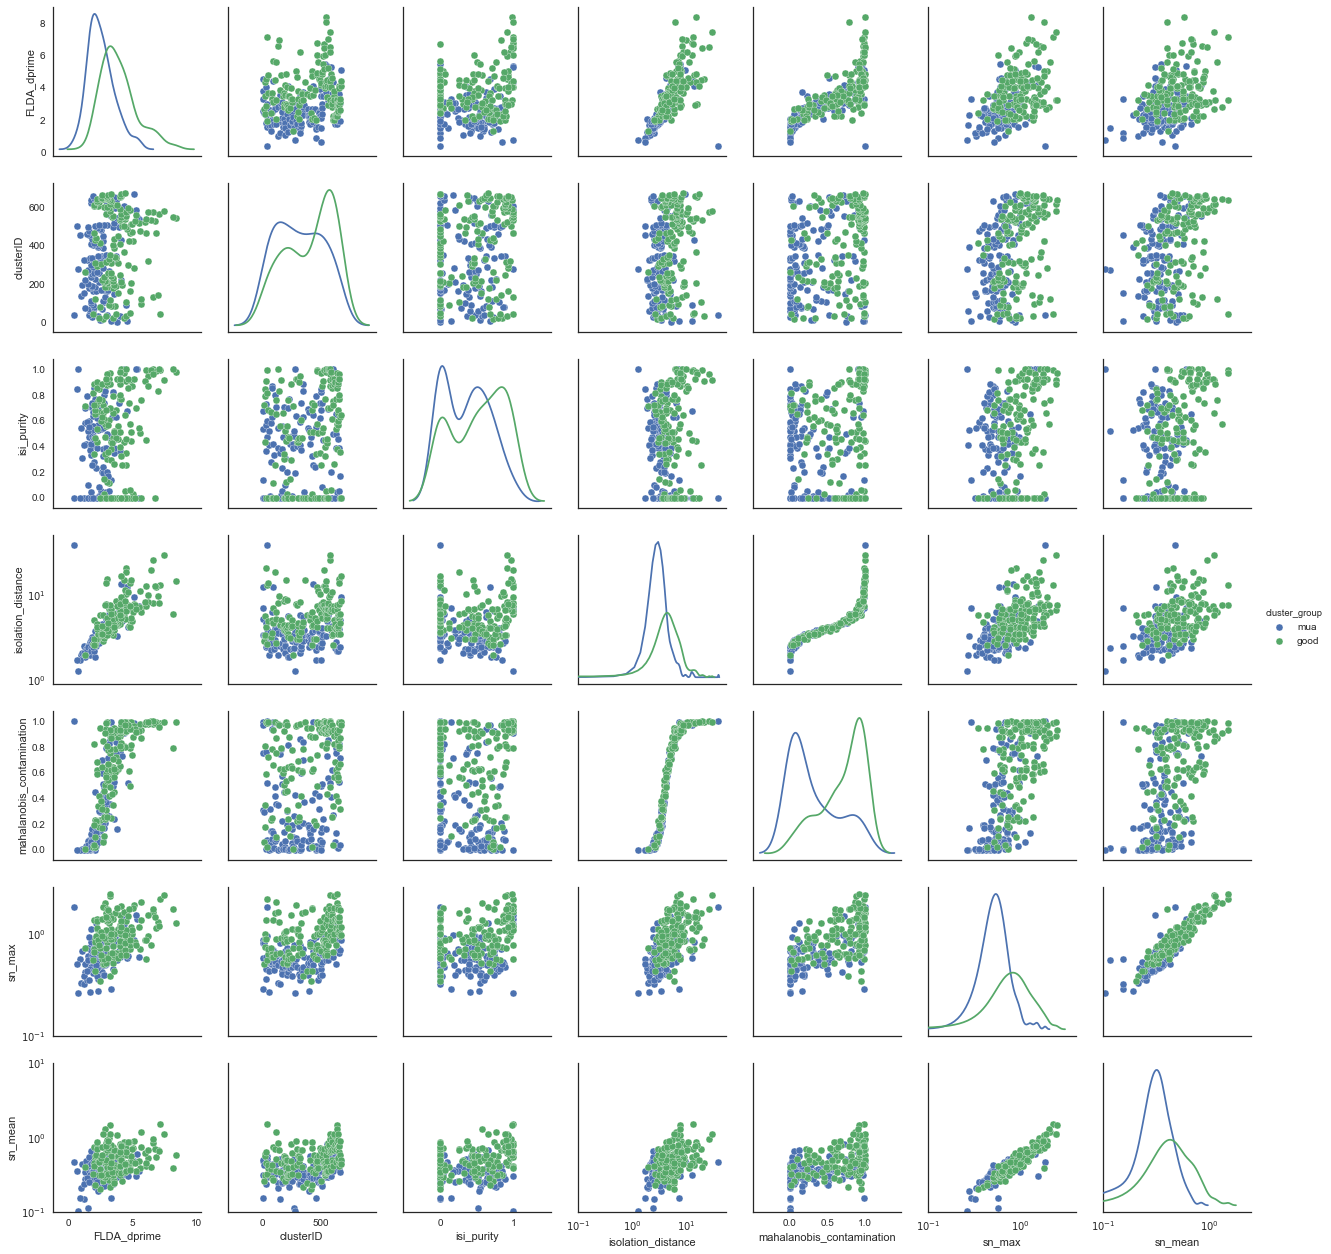

In [100]:
g=sns.pairplot(dft,
             diag_kind='kde',markers='o',hue='cluster_group',hue_order=['mua','good'])
logs = [3,5,6]
for row in range(np.shape(g.axes)[0]):
    for column in logs:
        axis = g.axes[row,column]
        axis.set_xscale('log')
        axis.set_xlim([.1,axis.get_xlim()[1]])
        if row in logs:
            axis = g.axes[row,column]
            axis.set_yscale('log')
            axis.set_ylim([.1,axis.get_ylim()[1]])
        if row == 3:
             axis.set_ylim([.9,axis.get_ylim()[1]])
        if row > 5:
            axis.set_ylim([.1,10])

In [40]:
metrics = dft.as_matrix(columns=['isi_purity',
                                    'sn_max',
                                    'sn_mean',
                                    'isolation_distance',
                                    'mahalanobis_contamination',
                                    'FLDA_dprime',
                                 ])
metrics = np.nan_to_num(metrics)

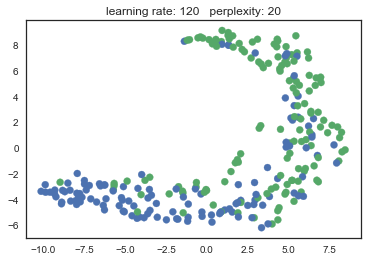

In [46]:
X_tsne = TSNE(learning_rate=120,perplexity=40).fit_transform(metrics)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1],c=np.array(dft.color))
plt.gca().set_title('learning rate: '+str(120)+'   perplexity: '+str(20))

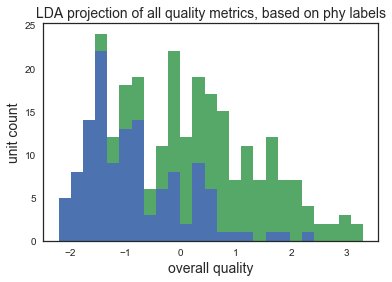

In [143]:
labels = np.zeros(np.shape(dft)[0])
labels[np.array(dft.cluster_group)=='good']=1
linear_quality = sq.project_linear_quality(metrics,labels)
d=plt.hist([linear_quality[labels==0],
          linear_quality[labels==1]],bins=25,stacked=True)
plt.xlabel('overall quality',size=14);plt.ylabel('unit count',size=14);plt.title('LDA projection of all quality metrics, based on phy labels',size=14)

### compare manual annotation with clustering-based determination of unit group

#### clustering: vanilla kmeans

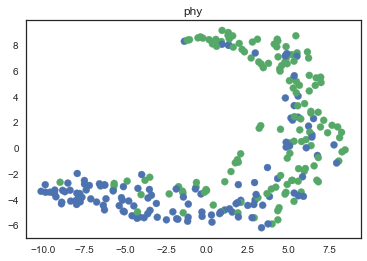

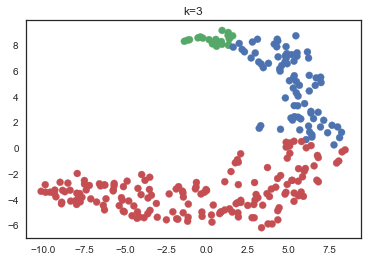

In [59]:
kn=3
km = kmeans2(metrics,
        kn, iter=300, thresh=5e-6,minit='points')
c2 = np.array([sns.color_palette()[k] for k in km[1]])
plt.scatter(X_tsne[:, 0], X_tsne[:, 1],c=np.array(dft.color))
plt.gca().set_title('phy')
plt.figure()
plt.scatter(X_tsne[:, 0], X_tsne[:, 1],c=c2)
plt.gca().set_title('k='+str(kn))

## plot individual unit summaries, showing data and metrics

no sampling rate specified, using default of 30kHz
['578', '390', '496']


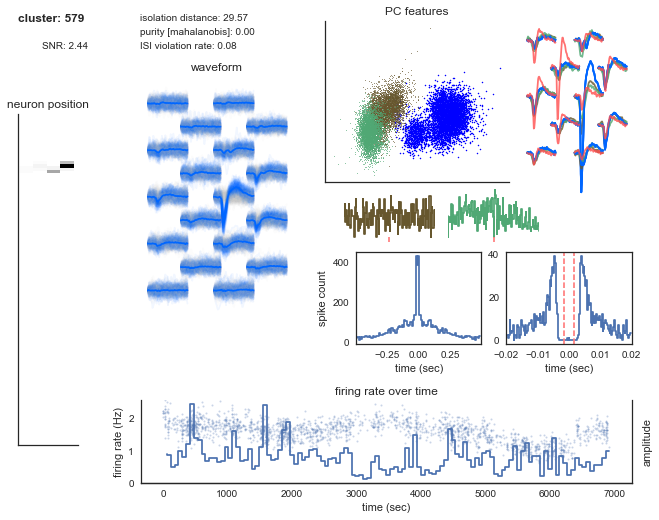

In [145]:
df_good = df[df.cluster_group=='good']
d=sq.neuron_fig(clusterID=str(df_good.clusterID[df.isolation_distance == df_good.isolation_distance.max()].values[0]),
                df=df,
                sortpath=directory,
               filename='experiment1_104-0_0.dat')